<a href="https://colab.research.google.com/github/Daniilsol200/KURSOVAI_kovalevski_Kurs3/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D1%8B%D0%B5%D0%A1%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [214]:
import numpy as np, random
import matplotlib.pyplot as plt

np.random.seed(42); random.seed(42)

# =========================
# 1) Подготовка данных
# =========================
text = """
Нейронные — это мощный инструмент, который способен находить закономерности в данных.
Они применяются в обработке языка, изображений, в прогнозировании и многом другом.
В этой небольшой демонстрации мы обучаем простые рекуррентные сети для предсказания следующего символа.
Искусственный интеллект, нейронные сети, машинное обучение — что на самом деле означают все эти нынче популярные понятия?
Для большинства непосвященных людей, коим являюсь и я сам, они всегда казались чем-то фантастическим.
Впервые понятие искусственных нейронных сетей (ИНС) возникло при попытке смоделировать процессы головного мозга.
Сегодня мы стоим на пороге новой эры, когда модели могут генерировать связный текст, решать сложные задачи и даже проходить экзамены лучше среднестатистического студента.
При этом базовые принципы остались те же: сеть получает входные данные, преобразует их через множество слоёв с весами, применяет нелинейные активации и постепенно учится предсказывать правильный ответ, минимизируя ошибку.
В нашей задаче посимвольного предсказания мы видим эти принципы в самом чистом виде: каждая буква, пробел или знак препинания превращается в вектор, подаётся в рекуррентную ячейку, а сеть должна угадать, какой символ идёт дальше.
Казалось бы, примитивно — но даже на таком простом примере прекрасно видно, насколько сильно лстм сети превосходит классические сети Элмана и Джордана по способности запоминать долгосрочные зависимости в последовательности.
Нейронные сети представляют собой особый подход к созданию искусственного интеллекта, основанный на принципах работы человеческого мозга. Эти системы состоят из многочисленных взаимосвязанных узлов, которые можно сравнить с нервными клетками. Каждый такой узел получает сведения, обрабатывает их и передает дальше, в результате чего сеть постепенно учится распознавать закономерности и принимать решения.
Обучение нейронной сети происходит путём многократного анализа примеров. Сначала система получает исходные данные и делает предположение о правильном ответе. Затем специальный алгоритм сравнивает полученный результат с эталоном и вычисляет величину ошибки. После этого связи между узлами немного изменяются таким образом, чтобы в следующий раз ошибка была меньше. Постепенное повторение этого процесса приводит к тому, что сеть всё точнее выполняет поставленную задачу.
Существует несколько типов нейронных сетей, и каждая из них подходит для определённых целей. Самые простые используются для анализа числовых данных и выполнения сравнительно несложных вычислений. Более сложные разновидности способны распознавать изображения, выделять на них объекты, понимать устную речь, переводить текст с одного языка на другой или анализировать временные последовательности, например изменения температуры, трафика или финансовых показателей. Особые виды нейронных сетей умеют создавать новые изображения, тексты и даже музыку, опираясь на изученные примеры.
Одной из главных причин популярности нейронных сетей является их способность самостоятельно находить сложные зависимости в больших объёмах данных. В отличие от традиционных программ, где человек заранее определяет правила, нейронная сеть извлекает необходимые закономерности сама. Это делает её особенно ценной в тех областях, где невозможно заранее описать все условия, например в медицине, где анализируются снимки и показания пациентов, или в сфере транспорта, где необходимо распознавать дорожную ситуацию.
При всех своих достоинствах нейронные сети имеют и недостатки. Им требуется много данных для обучения, причём эти данные должны быть достаточно качественными. Кроме того, работа таких систем нередко требует мощного оборудования. Ещё одной проблемой является то, что нейронная сеть действует как «чёрный ящик»: она даёт результат, но определить, почему именно он получился, бывает трудно.
Тем не менее развитие нейронных сетей продолжается очень быстро. Учёные стремятся сделать их более понятными, менее требовательными к ресурсам и способными обучаться на меньшем количестве примеров. Уже сегодня нейронные сети применяются в промышленности, медицине, науке, образовании, быту и развлечениях, и в будущем их роль будет только расти. Благодаря способности анализировать огромные массивы сведений и адаптироваться под новые задачи нейронные сети становятся одним из важнейших инструментов технологий будущего.
Нейронные сети всё чаще становятся основой современных технологий, поскольку позволяют решать задачи, которые раньше казались чрезвычайно сложными или вовсе невозможными. Их можно представить как множество взаимосвязанных элементов, которые обмениваются сигналами и постепенно учатся понимать окружающий мир. Такой подход напоминает работу человеческого мозга, где миллиарды клеток взаимодействуют друг с другом, формируя мысли, образы и решения.
Процесс обучения нейронной сети похож на обучение человека. Сначала она делает множество ошибок, неправильно реагирует на входные данные, но с каждым новым примером исправляется и становится точнее. Огромное преимущество таких систем состоит в том, что они способны учитывать множество факторов одновременно, замечать тонкие скрытые признаки и делать выводы, недоступные обычным алгоритмам.
Благодаря своим возможностям нейронные сети применяются в самых разных областях. В медицине они помогают врачам обнаруживать заболевания на ранней стадии, анализируя снимки и результаты обследований. В промышленности они используются для контроля качества продукции и прогнозирования возможных неисправностей оборудования. В сельском хозяйстве — для оценки состояния почвы, растений и планирования урожайности. В быту — в умных устройствах, которые распознают голос человека, управляют техникой, помогают выбирать музыку или фильмы.
Особенно впечатляет способность нейронных сетей создавать что-то новое. Они могут составлять тексты, рисовать картины, придумывать мелодии и даже имитировать почерк человека. Это открывает огромные возможности для творчества, образования и развлечений. При этом созданные сети продолжают развиваться, становясь всё более сложными и мощными.
Однако важно помнить, что нейронные сети требуют осторожного обращения. Поскольку они учатся на данных, то качество их работы полностью зависит от того, какие сведения они получают. Если данные искажены или неполны, сеть может сделать неправильные выводы. Поэтому разработчики тщательно подбирают информацию для обучения и контролируют процесс, чтобы результаты были максимально надёжными.
В будущем нейронные сети станут ещё более тесно связаны с повседневной жизнью. Они будут помогать принимать решения, работать, учиться и творить. Скорее всего, они станут такой же привычной частью жизни, как электричество или интернет. И хотя они не заменят человека, их возможности станут важным дополнением к человеческому разуму, расширяя горизонты науки, техники и искусства.
Современные нейронные сети становятся неотъемлемой частью научного прогресса. Их главное достоинство заключается в способности самостоятельно извлекать полезную информацию из больших массивов данных. Когда человеку нужно проанализировать огромное количество сведений, он может легко упустить важные детали. Нейронная сеть, напротив, способна обработать данные во всём их объёме и обнаружить скрытые закономерности, которые не видны невооружённым глазом.
Процесс работы нейронной сети основан на передаче сигналов между множеством связанных элементов. Каждый элемент получает данные, преобразует их и передаёт другим элементам. Сеть постепенно формирует внутренние связи, которые позволяют ей распознавать образы, понимать структуру информации и принимать решения. Благодаря этому нейронные сети успешно справляются с задачами, где требуется не просто вычисление, а именно понимание.
Одним из интересных свойств нейронных сетей является их способность улучшать свои результаты со временем. Чем больше примеров они анализируют, тем увереннее становятся их выводы. Таким образом, система постоянно совершенствуется, что позволяет применять её в меняющихся условиях. Например, если сеть отвечает за наблюдение за дорожной обстановкой, то с каждым днём она лучше различает машины, пешеходов и препятствия, делая управление транспортом более безопасным.
Нейронные сети уже нашли применение в искусстве, науке, промышленности и обучении. В художественной сфере они помогают создавать новые изображения и стили, а также вдохновляют творцов на необычные идеи. В научных исследованиях они ускоряют анализ сложных процессов, моделирование природных явлений и поиск закономерностей. В промышленности они позволяют предсказывать поломки техники, оптимизировать производство и снижать затраты. В обучении нейронные сети используются для создания индивидуальных программ, которые учитывают способности и темп каждого ученика.
Несмотря на все достижения, нейронные сети всё ещё находятся в стадии активного развития. Учёные продолжают искать новые способы ускорить обучение, уменьшить потребность в огромных вычислительных ресурсах и сделать работу таких систем понятнее для человека. Одной из главных задач является создание нейронных сетей, способных объяснять свои решения. Это особенно важно там, где цена ошибки слишком высока — например, в медицине или транспортной безопасности.
В будущем нейронные сети, вероятно, станут ещё более универсальными помощниками. Они смогут не только анализировать информацию, но и взаимодействовать с человеком almost на равных, понимать контекст, настроение, особенности мышления. Такой шаг позволит создать технику, которая не просто выполняет команды, а действительно понимает пользователя.
""".strip() * 2

text = text[:]
chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

data = np.array([char2idx[ch] for ch in text], dtype=np.int32)
X_all, Y_all = data[:-1], data[1:]
split = int(0.9 * len(X_all))
X_train, Y_train = X_all[:split], Y_all[:split]
X_test, Y_test = X_all[split:], Y_all[split:]
print(f"len text={len(text)}, vocab={vocab_size}, train={len(X_train)}, test={len(X_test)}")

len text=19058, vocab=66, train=17151, test=1906


In [193]:
import numpy as np, random
np.random.seed(42); random.seed(42)

# =========================
# 1) Подготовка данных
# =========================
text = """
Нейронные — это мощный инструмент, который способен находить закономерности в данных.
Они применяются в обработке языка, изображений, в прогнозировании и многом другом.
В этой небольшой демонстрации мы обучаем простые рекуррентные сети для предсказания следующего символа.
Искусственный интеллект, нейронные сети, машинное обучение — что на самом деле означают все эти нынче популярные понятия?
Для большинства непосвященных людей, коим являюсь и я сам, они всегда казались чем-то фантастическим.
Впервые понятие искусственных нейронных сетей (ИНС) возникло при попытке смоделировать процессы головного мозга.
Сегодня мы стоим на пороге новой эры, когда модели могут генерировать связный текст, решать сложные задачи и даже проходить экзамены лучше среднестатистического студента.
При этом базовые принципы остались те же: сеть получает входные данные, преобразует их через множество слоёв с весами, применяет нелинейные активации и постепенно учится предсказывать правильный ответ, минимизируя ошибку.
В нашей задаче посимвольного предсказания мы видим эти принципы в самом чистом виде: каждая буква, пробел или знак препинания превращается в вектор, подаётся в рекуррентную ячейку, а сеть должна угадать, какой символ идёт дальше.
Казалось бы, примитивно — но даже на таком простом примере прекрасно видно, насколько сильно лстм сети превосходит классические сети Элмана и Джордана по способности запоминать долгосрочные зависимости в последовательности.
""".strip() * 3

text = text[:]
chars = sorted(list(set(text)))
vocab_size = len(chars)
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for ch, i in char2idx.items()}

data = np.array([char2idx[ch] for ch in text], dtype=np.int32)
X_all, Y_all = data[:-1], data[1:]
split = int(0.9 * len(X_all))
X_train, Y_train = X_all[:split], Y_all[:split]
X_test, Y_test = X_all[split:], Y_all[split:]
print(f"len text={len(text)}, vocab={vocab_size}, train={len(X_train)}, test={len(X_test)}")

len text=4368, vocab=51, train=3930, test=437


In [215]:
# =========================
# 2) Вспомогательные функции
# =========================
def onehot(index, vocab_size):
    v = np.zeros(vocab_size, dtype=np.float32)
    v[index] = 1.0
    return v

def to_onehot_seq(indices, vocab_size):
    return [onehot(int(i), vocab_size) for i in indices]

def softmax(x):
    x = x - np.max(x)
    e = np.exp(x)
    return e / np.sum(e)

def cross_entropy_from_probs(probs, target_idx):
    return -np.log(probs[target_idx] + 1e-12)

def sample_with_temperature(p, T=1.0):
    p = np.asarray(p, dtype=np.float64)
    p = np.log(p + 1e-12) / T
    p = np.exp(p - np.max(p))
    p = p / np.sum(p)
    return np.random.choice(len(p), p=p)

In [216]:
# =========================
# 3) Elman RNN
# =========================
class ElmanRNN:
    def __init__(self, vocab_size, hidden_size=128):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6.0 / (vocab_size + hidden_size))
        self.Wxh = np.random.uniform(-limit, limit, (hidden_size, vocab_size)).astype(np.float32)
        self.Whh = np.random.uniform(-limit, limit, (hidden_size, hidden_size)).astype(np.float32)
        self.Why = np.random.uniform(-limit, limit, (vocab_size, hidden_size)).astype(np.float32)
        self.bh = np.zeros(hidden_size, dtype=np.float32)
        self.by = np.zeros(vocab_size, dtype=np.float32)

    def forward(self, inputs, h0=None):
        T = len(inputs)
        if h0 is None:
            h_prev = np.zeros(self.hidden_size, dtype=np.float32)
        else:
            h_prev = h0.copy()
        hs = np.zeros((T + 1, self.hidden_size), dtype=np.float32)
        hs[0] = h_prev
        ps = np.zeros((T, self.vocab_size), dtype=np.float32)
        for t in range(T):
            x = inputs[t]
            hs[t + 1] = np.tanh(self.Wxh @ x + self.Whh @ hs[t] + self.bh)
            o = self.Why @ hs[t + 1] + self.by
            ps[t] = softmax(o)
        return hs, ps

    def bptt(self, inputs, targets, lr=0.005, clip=5.0, h0=None):
        T = len(inputs)
        hs, ps = self.forward(inputs, h0)
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        loss = 0.0
        dh_next = np.zeros(self.hidden_size, dtype=np.float32)

        for t in range(T):
            loss += cross_entropy_from_probs(ps[t], int(targets[t]))

        for t in reversed(range(T)):
            dy = ps[t].copy()
            dy[int(targets[t])] -= 1.0
            dWhy += np.outer(dy, hs[t + 1])
            dby += dy
            dh = self.Why.T @ dy + dh_next
            dh_raw = (1.0 - hs[t + 1] ** 2) * dh
            dbh += dh_raw
            dWxh += np.outer(dh_raw, inputs[t])
            dWhh += np.outer(dh_raw, hs[t])
            dh_next = self.Whh.T @ dh_raw

        for g in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(g, -clip, clip, out=g)

        self.Wxh -= lr * dWxh
        self.Whh -= lr * dWhh
        self.Why -= lr * dWhy
        self.bh -= lr * dbh
        self.by -= lr * dby

        return loss / T, hs[-1].copy()

    def predict_next(self, x_onehot, h_prev):
        h = np.tanh(self.Wxh @ x_onehot + self.Whh @ h_prev + self.bh)
        o = self.Why @ h + self.by
        p = softmax(o)
        return p, h

In [217]:
# =========================
# 4) Jordan RNN
# =========================
class JordanRNN:
    def __init__(self, vocab_size, hidden_size=128):
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        limit = np.sqrt(6.0 / (vocab_size + hidden_size))
        self.Wxh = np.random.uniform(-limit, limit, (hidden_size, vocab_size)).astype(np.float32)
        self.Wch = np.random.uniform(-limit, limit, (hidden_size, vocab_size)).astype(np.float32)
        self.Why = np.random.uniform(-limit, limit, (vocab_size, hidden_size)).astype(np.float32)
        self.bh = np.zeros(hidden_size, dtype=np.float32)
        self.by = np.zeros(vocab_size, dtype=np.float32)

    def forward(self, inputs, ctx0=None):
        T = len(inputs)
        if ctx0 is None:
            ctx_prev = np.zeros(self.vocab_size, dtype=np.float32)
        else:
            ctx_prev = ctx0.copy()
        hs = np.zeros((T + 1, self.hidden_size), dtype=np.float32)
        ps = np.zeros((T, self.vocab_size), dtype=np.float32)
        for t in range(T):
            x = inputs[t]
            hs[t + 1] = np.tanh(self.Wxh @ x + self.Wch @ ctx_prev + self.bh)
            o = self.Why @ hs[t + 1] + self.by
            p = softmax(o)
            ps[t] = p
            ctx_prev = p
        return hs, ps

    def bptt(self, inputs, targets, lr=0.01, clip=5.0, ctx0=None):
        T = len(inputs)
        hs, ps = self.forward(inputs, ctx0)
        dWxh = np.zeros_like(self.Wxh)
        dWch = np.zeros_like(self.Wch)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)
        loss = 0.0

        for t in range(T):
            loss += cross_entropy_from_probs(ps[t], int(targets[t]))

        for t in reversed(range(T)):
            dy = ps[t].copy()
            dy[int(targets[t])] -= 1.0
            dWhy += np.outer(dy, hs[t + 1])
            dby += dy
            dh = self.Why.T @ dy
            dh_raw = (1.0 - hs[t + 1] ** 2) * dh
            dbh += dh_raw
            dWxh += np.outer(dh_raw, inputs[t])
            if t > 0:
                dWch += np.outer(dh_raw, ps[t - 1])
        for g in [dWxh, dWch, dWhy, dbh, dby]:
            np.clip(g, -clip, clip, out=g)

        self.Wxh -= lr * dWxh
        self.Wch -= lr * dWch
        self.Why -= lr * dWhy
        self.bh -= lr * dbh
        self.by -= lr * dby

        return loss / T, ps[-1].copy()

    def predict_next(self, x_onehot, ctx_prev):
        h = np.tanh(self.Wxh @ x_onehot + self.Wch @ ctx_prev + self.bh)
        o = self.Why @ h + self.by
        p = softmax(o)
        return p, h, p

In [218]:
# =========================
# 5) Обучение
# =========================

def train_model(model, X, Y, seq_len=60, epochs=100, lr=0.005, name="Model"):
    n = len(X)
    base_lr = lr
    if isinstance(model, ElmanRNN):
        state = np.zeros(model.hidden_size, dtype=np.float32)
    else:
        state = np.zeros(model.vocab_size, dtype=np.float32)

    losses = []
    for epoch in range(1, epochs + 1):
        lr = base_lr * (0.97 ** (epoch // 5))
        total_loss = 0.0
        count = 0
        for i in range(0, n - seq_len, seq_len):
            X_seq = to_onehot_seq(X[i:i + seq_len], model.vocab_size)
            Y_seq = Y[i:i + seq_len]
            if isinstance(model, ElmanRNN):
                loss, state = model.bptt(X_seq, Y_seq, lr=lr, clip=1.0, h0=state)
                state = np.clip(state, -5, 5)
            else:
                loss, state = model.bptt(X_seq, Y_seq, lr=lr, clip=1.0, ctx0=state)
                state = np.clip(state, 0, 1)
            total_loss += loss * len(X_seq)
            count += len(X_seq)
        avg_loss = total_loss / count
        losses.append(avg_loss)
        if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
            print(f"[{name}] epoch {epoch}/{epochs}, avg loss={avg_loss:.4f}, lr={lr:.5f}")
    return losses

In [219]:
# =========================
# 6) Accuracy и генерация
# =========================
def compute_accuracy(model, X, Y):
    correct, total = 0, 0
    if isinstance(model, ElmanRNN):
        h = np.zeros(model.hidden_size, dtype=np.float32)
        for i in range(len(X)):
            x = onehot(int(X[i]), model.vocab_size)
            p, h = model.predict_next(x, h)
            if np.argmax(p) == int(Y[i]):
                correct += 1
            total += 1
    else:
        ctx = np.zeros(model.vocab_size, dtype=np.float32)
        for i in range(len(X)):
            x = onehot(int(X[i]), model.vocab_size)
            p, h, ctx = model.predict_next(x, ctx)
            if np.argmax(p) == int(Y[i]):
                correct += 1
            total += 1
    return correct / total

def generate(model, seed, length=200, T=0.8):
    out = seed
    if isinstance(model, ElmanRNN):
        h = np.zeros(model.hidden_size, dtype=np.float32)
        for ch in seed[:-1]:
            x = onehot(char2idx.get(ch, 0), model.vocab_size)
            _, h = model.predict_next(x, h)
        last_idx = char2idx.get(seed[-1], 0)
        for _ in range(length):
            x = onehot(last_idx, model.vocab_size)
            p, h = model.predict_next(x, h)
            next_idx = sample_with_temperature(p, T)
            out += idx2char[next_idx]
            last_idx = next_idx
    else:
        ctx = np.zeros(model.vocab_size, dtype=np.float32)
        for ch in seed[:-1]:
            x = onehot(char2idx.get(ch, 0), model.vocab_size)
            p, h, ctx = model.predict_next(x, ctx)
        last_idx = char2idx.get(seed[-1], 0)
        for _ in range(length):
            x = onehot(last_idx, model.vocab_size)
            p, h, ctx = model.predict_next(x, ctx)
            next_idx = sample_with_temperature(p, T)
            out += idx2char[next_idx]
            last_idx = next_idx
    return out

In [220]:
# =============================================
# 7) Запуск обучения
# =============================================
elman = ElmanRNN(vocab_size, hidden_size=128)
jordan = JordanRNN(vocab_size, hidden_size=128)

print("\nTraining ElmanRNN...")
elman_losses = train_model(elman, X_train, Y_train, seq_len=80, epochs=100, lr=0.005, name="Elman")

print("\nTraining JordanRNN...")
jordan_losses = train_model(jordan, X_train, Y_train, seq_len=80, epochs=100, lr=0.01, name="Jordan")



Training ElmanRNN...
[Elman] epoch 1/100, avg loss=3.1296, lr=0.00500
[Elman] epoch 5/100, avg loss=2.1751, lr=0.00485
[Elman] epoch 10/100, avg loss=1.8730, lr=0.00470
[Elman] epoch 15/100, avg loss=1.7040, lr=0.00456
[Elman] epoch 20/100, avg loss=1.5958, lr=0.00443
[Elman] epoch 25/100, avg loss=1.4968, lr=0.00429
[Elman] epoch 30/100, avg loss=1.4441, lr=0.00416
[Elman] epoch 35/100, avg loss=1.3830, lr=0.00404
[Elman] epoch 40/100, avg loss=1.3007, lr=0.00392
[Elman] epoch 45/100, avg loss=1.2382, lr=0.00380
[Elman] epoch 50/100, avg loss=1.1821, lr=0.00369
[Elman] epoch 55/100, avg loss=1.1368, lr=0.00358
[Elman] epoch 60/100, avg loss=1.0812, lr=0.00347
[Elman] epoch 65/100, avg loss=1.0500, lr=0.00337
[Elman] epoch 70/100, avg loss=0.9867, lr=0.00326
[Elman] epoch 75/100, avg loss=0.9296, lr=0.00317
[Elman] epoch 80/100, avg loss=0.8613, lr=0.00307
[Elman] epoch 85/100, avg loss=0.8463, lr=0.00298
[Elman] epoch 90/100, avg loss=0.8011, lr=0.00289
[Elman] epoch 95/100, avg loss

In [246]:
# =========================
# 8) ГОТОВАЯ LSTM ИЗ PyTorch
# =========================
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class PyTorchLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=128, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.input_proj = nn.Linear(vocab_size, vocab_size, bias=False)
        self.lstm = nn.LSTM(vocab_size, hidden_size, num_layers, batch_first=True)
        self.output_proj = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):

        if x.dim() == 1:
            x = x.unsqueeze(0)

        x_onehot = torch.zeros(x.size(0), x.size(1), vocab_size, device=x.device)
        x_onehot.scatter_(2, x.unsqueeze(-1), 1.0) # настоящие one-hot тензоры

        x_emb = self.input_proj(x_onehot)
        out, hidden = self.lstm(x_emb, hidden)
        out = self.output_proj(out)
        return out, hidden

X_train_t = torch.from_numpy(X_train).long().to(device)
Y_train_t = torch.from_numpy(Y_train).long().to(device)
X_test_t = torch.from_numpy(X_test).long().to(device)
Y_test_t = torch.from_numpy(Y_test).long().to(device)

torch_lstm = PyTorchLSTM(vocab_size, hidden_size=128, num_layers=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(torch_lstm.parameters(), lr=0.005)

print("\nTraining PyTorch LSTM")
seq_len = 80
epochs =45
lstm_losses = []

for epoch in range(1, epochs + 1):
    torch_lstm.train()
    total_loss = 0.0
    count = 0
    i = 0
    while i + seq_len < len(X_train_t):
        seq = X_train_t[i:i + seq_len]
        target = Y_train_t[i:i + seq_len]
        optimizer.zero_grad()
        output, _ = torch_lstm(seq)
        loss = criterion(output.view(-1, vocab_size), target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(torch_lstm.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item() * seq_len
        count += seq_len
        i += seq_len

    avg_loss = total_loss / count if count > 0 else 0
    lstm_losses.append(avg_loss)

    if epoch % 5 == 0 or epoch == 1 or epoch == epochs:
        print(f"[PyTorch LSTM] epoch {epoch}/{epochs}, avg loss={avg_loss:.4f}")

# --------------------- Accuracy ---------------------
def compute_accuracy_torch(model, X, Y):
    model.eval()
    correct = 0
    hidden = None
    with torch.no_grad():
        for i in range(len(X)):
            x = X[i].unsqueeze(0)
            y = Y[i]
            output, hidden = model(x, hidden)
            pred = output[0, -1].argmax().item()
            if pred == y.item():
                correct += 1
    return correct / len(X)

acc_pt = compute_accuracy_torch(torch_lstm, X_test_t, Y_test_t)

# --------------------- Генерация ---------------------
def generate_torch(model, seed_text, length=600, temperature=0.7):
    model.eval()
    generated = seed_text
    hidden = None

    # Прогрев сети по символам из seed
    for ch in seed_text:
        idx = torch.tensor([[char2idx[ch]]], device=device)
        _, hidden = model(idx, hidden)

    cur_idx = char2idx[seed_text[-1]]
    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor([[cur_idx]], device=device)
            output, hidden = model(x, hidden)
            logits = output[0, -1] / temperature
            probs = torch.softmax(logits, dim=-1).cpu().numpy()
            cur_idx = np.random.choice(vocab_size, p=probs)
            generated += idx2char[cur_idx]
    return generated

Using device: cpu

Training PyTorch LSTM
[PyTorch LSTM] epoch 1/45, avg loss=2.6959
[PyTorch LSTM] epoch 5/45, avg loss=1.3586
[PyTorch LSTM] epoch 10/45, avg loss=0.7878
[PyTorch LSTM] epoch 15/45, avg loss=0.5211
[PyTorch LSTM] epoch 20/45, avg loss=0.3964
[PyTorch LSTM] epoch 25/45, avg loss=0.3239
[PyTorch LSTM] epoch 30/45, avg loss=0.2835
[PyTorch LSTM] epoch 35/45, avg loss=0.2675
[PyTorch LSTM] epoch 40/45, avg loss=0.2854
[PyTorch LSTM] epoch 45/45, avg loss=0.2728


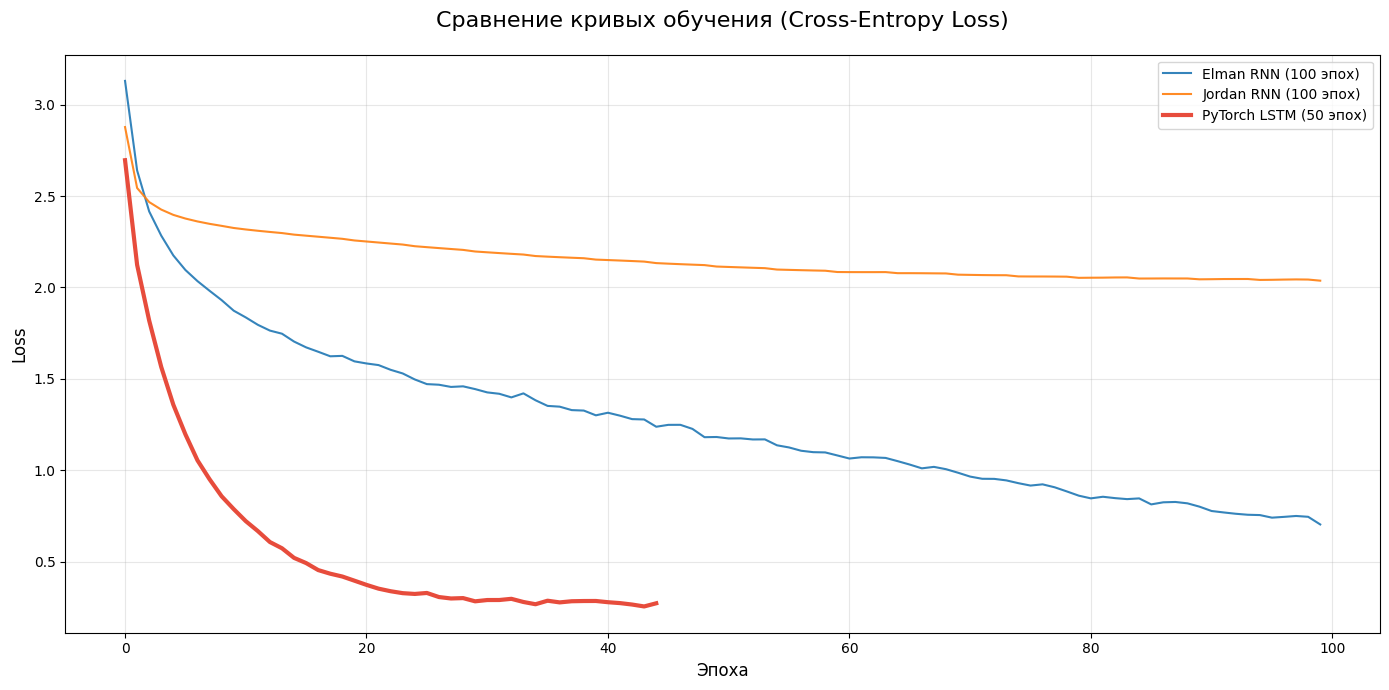

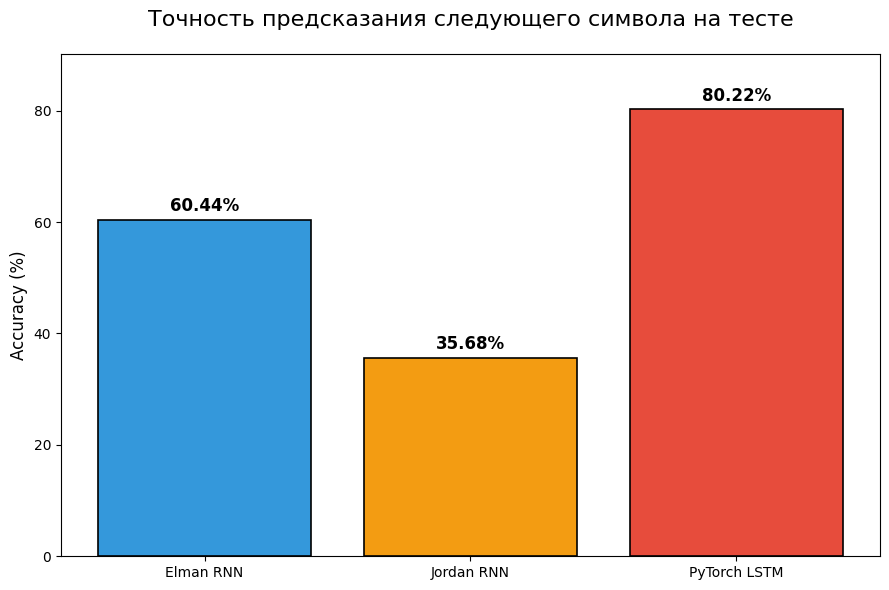


Accuracy — Elman: 60.44%, Jordan: 35.68%, PyTorch LSTM: 80.22%


In [247]:
# =============================================
# 9) ГРАФИКИ
# =============================================
acc_e = compute_accuracy(elman, X_test, Y_test)
acc_j = compute_accuracy(jordan, X_test, Y_test)
acc_pt = compute_accuracy_torch(torch_lstm, X_test_t, Y_test_t)

# --------------------- ГРАФИКИ ---------------------
plt.figure(figsize=(14, 7))
plt.plot(elman_losses, label="Elman RNN (100 эпох)", alpha=0.9)
plt.plot(jordan_losses, label="Jordan RNN (100 эпох)", alpha=0.9)
plt.plot(lstm_losses, label="PyTorch LSTM (50 эпох)", linewidth=3, color="#e74c3c")
plt.title("Сравнение кривых обучения (Cross-Entropy Loss)", fontsize=16, pad=20)
plt.xlabel("Эпоха", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6))
models = ["Elman RNN", "Jordan RNN", "PyTorch LSTM"]
accs = [acc_e * 100, acc_j * 100, acc_pt * 100]
colors = ["#3498db", "#f39c12", "#e74c3c"]
bars = plt.bar(models, accs, color=colors, edgecolor="black", linewidth=1.2)
plt.title("Точность предсказания следующего символа на тесте", fontsize=16, pad=20)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, max(accs) + 10)

for bar, acc in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8,
             f"{acc:.2f}%", ha="center", va="bottom", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

print(f"\nAccuracy — Elman: {acc_e*100:.2f}%, Jordan: {acc_j*100:.2f}%, PyTorch LSTM: {acc_pt*100:.2f}%")

In [252]:
seed = "Нейронные се"

print("\n→ Elman RNN:")
print(generate(elman, seed, length=100, T=0.7))

print("\n→ Jordan RNN:")
print(generate(jordan, seed, length=100, T=0.7))

print("\n→ PyTorch LSTM (самая качественная):")
print(generate_torch(torch_lstm, seed, length=100, temperature=0.7))


→ Elman RNN:
Нейронные сети применяются в промышранные —премения, нейронные сети требуют сведенятся и обучать меноширожного я

→ Jordan RNN:
Нейронные сет и мимем деть полумные приннот даже обонные сется не. рапрест еть при, янные и иния, Онные и изнанн

→ PyTorch LSTM (самая качественная):
Нейронные сет способность нейронные сети становятся основой создая имии всё более сложные разновидности, медицин
